In [1]:
import pandas as pd
import numpy as np
from random import randrange
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
wine_df = pd.read_csv('Downloads/winequality-red.csv', delimiter=";")

In [3]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
wine_df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

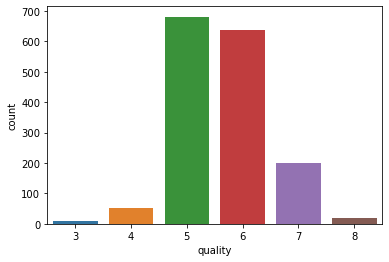

In [5]:
sns.countplot(wine_df['quality'],label="Count")

#### To simplify task as binary classification, rerank quality <6 as 0, >= 6 as 1.

In [6]:
wine_df['target'] = pd.to_numeric((wine_df['quality'] > 5) & (wine_df['quality'] < 9)).astype(int)

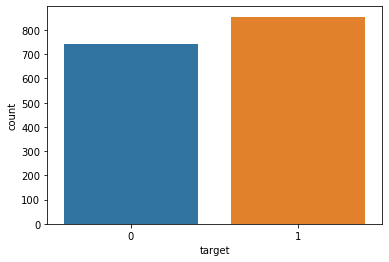

In [7]:
sns.countplot(wine_df['target'],label="Count")

In [8]:
# Standardize Data
for column in wine_df.columns[:-1]:
    wine_df[column] = (wine_df[column] - wine_df[column].mean()) / wine_df[column].std()

In [12]:

class LogisticRegression:
    
    def __init__(self, percentage=0.5, lr=0.01, max_iter=10000, beta=0.99, reg_term=0):  # percentage = train/cv+test split
        #self.data = data
        self.percentage = percentage
        self.gradient_values, self.train_acc_values, self.cv_acc_values = [], [], []
        self.cv_acc, self.select_line = 0, 0
        self.learning_rate = lr
        self.max_iter = max_iter
        self.beta = beta
        self.reg_term = reg_term
        
    def predict_proba(self, X, theta):
        return self.sigmoid(np.dot(X, theta))

    def predict(self, X, theta):
        prediction = self.predict_proba(X, theta)
        predict_arr = []
        for i in prediction:
            if i>=0.5:
                predict_arr.append(1)
            else:
                predict_arr.append(0)

        return predict_arr

    def accuracy(self, predict_arr, y):
        correct = 0
        for i,j in zip(predict_arr, y):
            if i==j[0]:
                correct+=1
        return correct/len(y)  # accuracy = # tp+tn / total

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def gradient(self, X, y, theta, lambdaa):  # lambdaa is regularization term
        N, D = len(X[0]), len(X[0])
        yh = self.sigmoid(np.dot(X, theta))
        grad = np.dot(X.T, yh-y) / N
        grad[1:] += lambdaa * theta[1:]
        return grad
    
    def fit(self, X, y, cv_X, cv_y, learning_rate=0.1, max_iter=10000, beta=0.99, reg_term=0.5):  # attempted termination condition - lack of improvement in cross validation set
        learning_rate = self.learning_rate
        max_iter = self.max_iter
        beta = self.beta
        reg_term = self.reg_term
        N, D = len(X[0]), len(X[0])
        theta = np.zeros((len(X[0]), 1))
        y = np.reshape(y, (-1,1))  # creates two-dimensional array
        cv_y = np.reshape(cv_y, (-1,1))
        iterate, cv_acc, prev_cv_acc, d_theta = 0, 0, 0, 0
        max_cv_acc = 0  # maximum cross validation accuracy - records thetas at highest cv_acc 
        best_theta = theta
        g = np.inf
        eps = 1e-2
        while (np.linalg.norm(g) > eps):  # can add in 'or cv_acc>=prev_cv_acc-0.03' to stop when gradient becomes too small, 0.03 gives buffer
            g = self.gradient(X, y, theta, reg_term)
            d_theta = (1-beta)*g + beta*d_theta  # momentum
            theta = theta-learning_rate*d_theta
            
            if iterate % 10 == 0:
                cv_pred = self.predict(cv_X, theta)
                prev_cv_acc = cv_acc
                cv_acc = self.accuracy(cv_pred, cv_y)
                train_pred = self.predict(X, theta)
                train_acc = self.accuracy(train_pred, y)
            if cv_acc >= max_cv_acc:  # checks if maximum accuracy thus far
                max_cv_acc = cv_acc
                best_theta = theta
                self.select_line = iterate
            iterate+=1
            self.gradient_values.append(np.linalg.norm(g))
            self.train_acc_values.append(train_acc)
            self.cv_acc_values.append(cv_acc)
#             if iterate % 100 == 0:
#                 print(np.linalg.norm(g)/len(X))
            if iterate > max_iter:  # since it may not always converge, place a hard ceiling on number of iterations
                break
        print(max_cv_acc)
        print(cv_acc)
        self.cv_acc = max_cv_acc
        return best_theta
    
    def get_test_acc(self, test_X, test_y, thetas):
        test_y = np.reshape(test_y, (-1,1))
        
        return self.accuracy(self.predict(test_X, thetas), test_y)

In [10]:
new_input = wine_df.drop(['quality'], axis=1)
new_input.insert(0, column='Bias', value=1)
new_input = new_input.sample(frac=1)  # randomly shuffles dataset

0.7398119122257053
0.7304075235109718


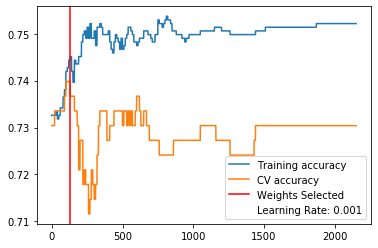

0.7366771159874608
0.7241379310344828


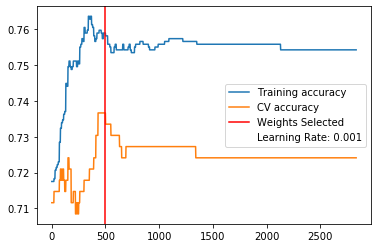

0.768025078369906
0.7460815047021944


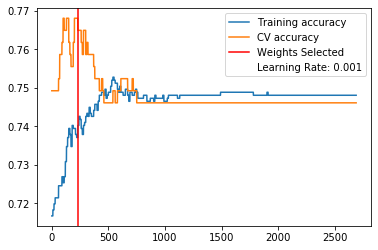

0.7366771159874608
0.7272727272727273


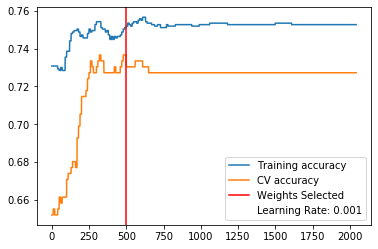

0.780564263322884
0.774294670846395


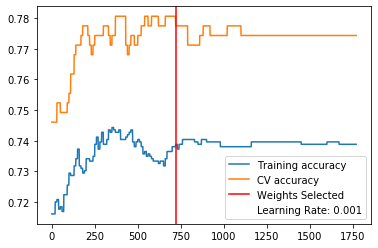

Average Accuracy: 0.7523510971786833
0.7398119122257053
0.7304075235109718


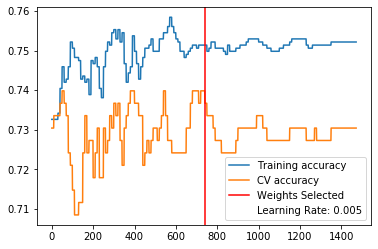

0.7460815047021944
0.7241379310344828


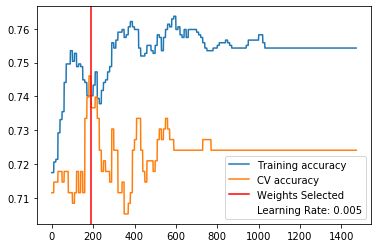

0.768025078369906
0.7460815047021944


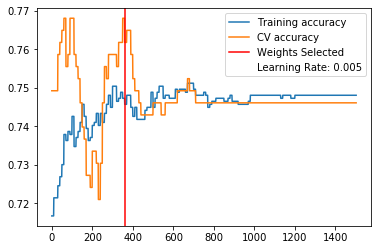

0.7398119122257053
0.7272727272727273


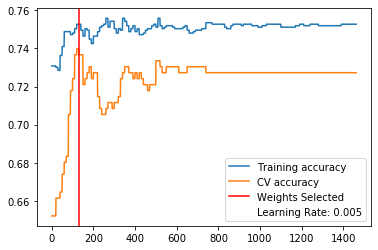

0.786833855799373
0.774294670846395


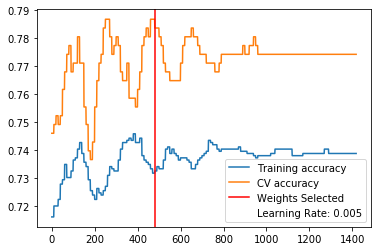

Average Accuracy: 0.7542319749216301
0.7398119122257053
0.7272727272727273


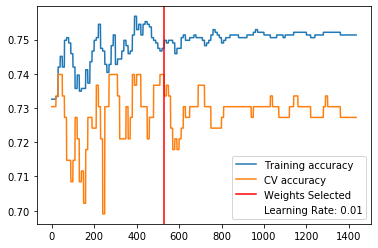

0.7366771159874608
0.7241379310344828


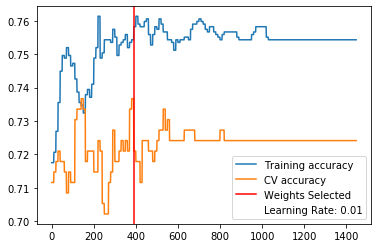

0.7711598746081505
0.7460815047021944


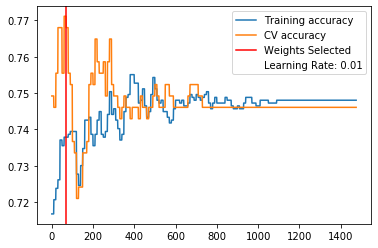

0.7398119122257053
0.7272727272727273


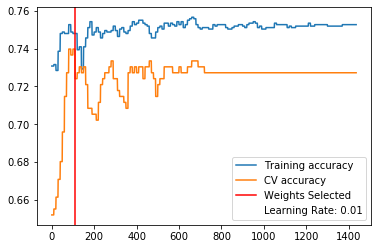

0.7899686520376176
0.774294670846395


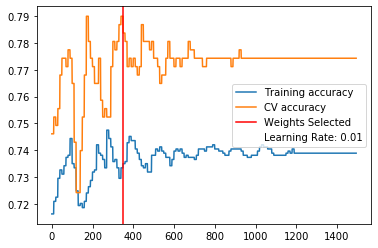

Average Accuracy: 0.754649947753396
0.7460815047021944
0.7272727272727273


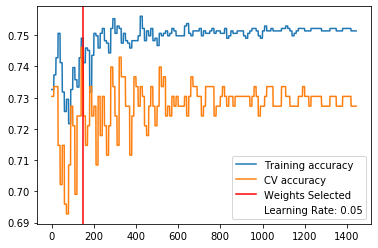

0.7554858934169278
0.7241379310344828


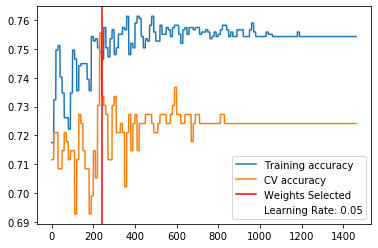

0.7648902821316614
0.7460815047021944


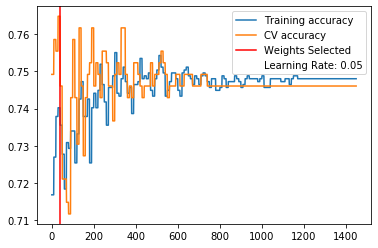

0.7366771159874608
0.7272727272727273


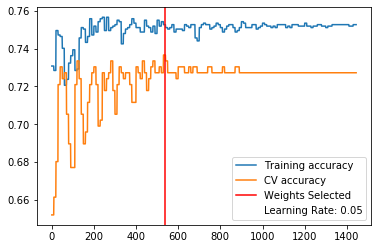

0.7899686520376176
0.774294670846395


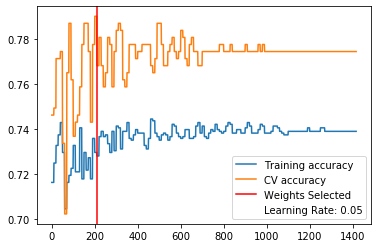

Average Accuracy: 0.7556426332288401
0.7492163009404389
0.7272727272727273


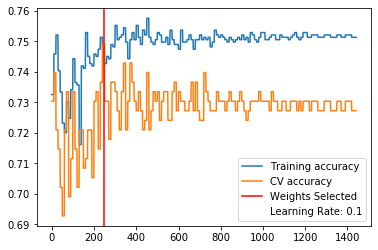

0.7429467084639498
0.7241379310344828


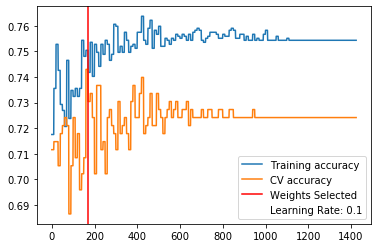

0.768025078369906
0.7460815047021944


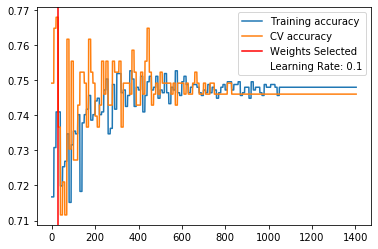

0.7398119122257053
0.7272727272727273


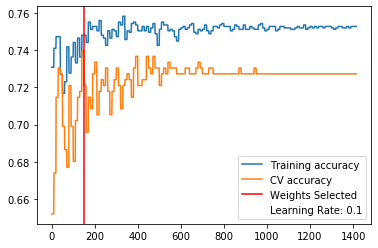

0.7899686520376176
0.774294670846395


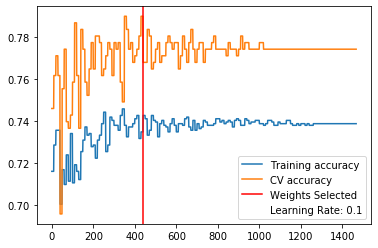

Average Accuracy: 0.7561128526645768


In [43]:

folds = 5
accuracies = []
learning_rate = [0.001, 0.005, 0.01, 0.05, 0.1]
for lr in learning_rate:
    for i in range(folds):

        start_bias = 0
        end_bias = 1
        if i>0:
            start_bias = 1  # to exclude last term in previous partition
        if i >= folds-1:
            end_bias = 0
        percentage = 1/folds
        length = len(new_input)
        test_set = new_input.iloc[int(percentage*(i)*length+start_bias):int(percentage*(i+1)*length), :]

        train_set_1 = new_input.iloc[int(percentage*(i+1)*length)+end_bias:length, :]
        train_set_2 = new_input.iloc[0:int(percentage*(i)*length), :]
        train_set = pd.concat([train_set_1, train_set_2])
        
        train_X = train_set.iloc[:, :-1]
        train_y = train_set.iloc[:, -1]

        test_X = test_set.iloc[:, :-1]
        test_y = test_set.iloc[:, -1]
        
        log_reg = LogisticRegression(percentage=0.6, lr = lr)
        log_reg.fit(train_X.values, train_y.values, test_X.values, test_y.values)
        accuracies.append(log_reg.cv_acc)
        plt.figure()
        plt.plot(log_reg.train_acc_values, label = 'Training accuracy')
        plt.plot(log_reg.cv_acc_values, label='CV accuracy')
        plt.axvline(log_reg.select_line, color='r', label='Weights Selected')
        plt.plot([], [], ' ', label="Learning Rate: "+str(log_reg.learning_rate))
        plt.legend()
        plt.show()
    print("Average Accuracy: "+str(np.mean(accuracies)))
